import區

In [5]:
# 基本處理與警告設定
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 繪圖與視覺化
import matplotlib.pyplot as plt
import seaborn as sns

# 資料前處理
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# 模型與評估
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    average_precision_score,
    f1_score
)
from sklearn.inspection import permutation_importance

# SHAP 模型解釋
import shap
from shap import TreeExplainer

讀取資料

In [6]:
# === Step 1: 載入資料 ===
df = pd.read_csv("heart-attack-risk-prediction-dataset.csv")

# === Step 2: 缺失值填補 ===
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].fillna(df[column].mode()[0])
    else:
        df[column] = df[column].fillna(df[column].median())

# === Step 3: 類別資料處理（Gender）===
# 將 Gender 統一轉成 Male/Female 字串後再轉 Label
df["Gender"] = df["Gender"].replace({"1.0": "Male", 1.0: "Male", "0.0": "Female", 0.0: "Female"})
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])  # Male=1, Female=0

# === Step 4: 目標變數與欄位過濾 ===
target_column = "Heart Attack Risk (Binary)"
if target_column not in df.columns:
    raise KeyError(f"Target column '{target_column}' not found in dataset.")

# 移除不需要的欄位
drop_cols = [
    'Heart Attack Risk (Binary)', 'Heart Attack Risk (Text)',
    'Cholesterol', 'Triglycerides', 'CK-MB', 'Troponin',
    'Diastolic blood pressure'
]
X = df.drop(columns=drop_cols)
y = df[target_column]
feature_names = X.columns.tolist()


資料切分

In [7]:
# === Step 5: 資料切分 ===
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=random_state, stratify=y
)

# === Step 6: SMOTETomek 平衡資料 ===
smote_tomek = SMOTETomek(random_state=random_state)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

# === Step 7: 顯示最終特徵 ===
print("最終使用的特徵欄位：")
for i, col in enumerate(feature_names, 1):
    print(f"{i:>2}. {col}")

最終使用的特徵欄位：
 1. Age
 2. Heart rate
 3. Diabetes
 4. Family History
 5. Smoking
 6. Obesity
 7. Alcohol Consumption
 8. Exercise Hours Per Week
 9. Diet
10. Previous Heart Problems
11. Medication Use
12. Stress Level
13. Sedentary Hours Per Day
14. Income
15. BMI
16. Physical Activity Days Per Week
17. Sleep Hours Per Day
18. Blood sugar
19. Gender
20. Systolic blood pressure


訓練

In [8]:
rf = RandomForestClassifier(
    n_estimators=150,
    random_state=random_state,
    max_depth=None,
    bootstrap=False,
)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_test)[:, 1]

y_pred_rf = (y_proba_rf >= 0.27).astype(int)

print("F1-score:", f1_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Average Precision (PR AUC)
ap_score = average_precision_score(y_test, y_proba_rf)
print("Average Precision (PR AUC):", ap_score)

F1-score: 0.5399828030954428
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.18      0.30       633
         1.0       0.38      0.94      0.54       333

    accuracy                           0.45       966
   macro avg       0.62      0.56      0.42       966
weighted avg       0.69      0.45      0.39       966

Average Precision (PR AUC): 0.48162327023412094


輸出SHAP

第 848 筆預測： 0.0
實際標籤： 1.0


Age                                0.674157
Heart rate                         0.025665
Diabetes                           1.000000
Family History                     1.000000
Smoking                            1.000000
Obesity                            1.000000
Alcohol Consumption                1.000000
Exercise Hours Per Week            0.818964
Diet                               1.000000
Previous Heart Problems            0.000000
Medication Use                     1.000000
Stress Level                       5.000000
Sedentary Hours Per Day            0.701850
Income                             0.799905
BMI                                0.809857
Physical Activity Days Per Week    1.000000
Sleep Hours Per Day                1.000000
Blood sugar                        0.227018
Gender                             1.000000
Systolic blood pressure            0.645161
Name: 2674, dtype: float64

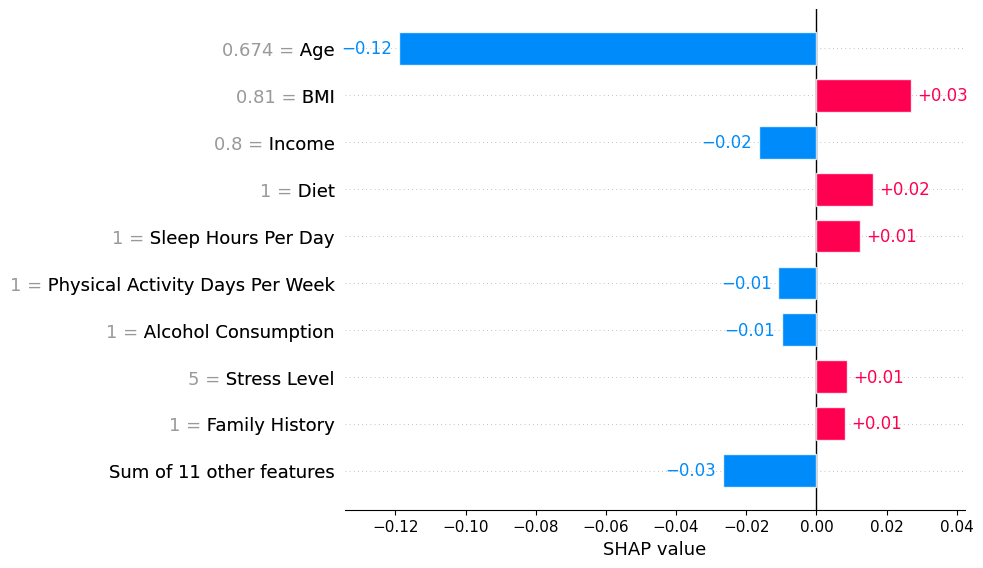

<class 'shap._explanation.Explanation'>
.values =
array([[ 0.11910973, -0.11910973],
       [ 0.00262223, -0.00262223],
       [-0.00562906,  0.00562906],
       [-0.00813774,  0.00813774],
       [ 0.00126068, -0.00126068],
       [ 0.00490211, -0.00490211],
       [ 0.00988145, -0.00988145],
       [ 0.00349668, -0.00349668],
       [-0.01619499,  0.01619499],
       [ 0.00515036, -0.00515036],
       [ 0.00487547, -0.00487547],
       [-0.00881716,  0.00881716],
       [-0.00743033,  0.00743033],
       [ 0.01648062, -0.01648062],
       [-0.02691881,  0.02691881],
       [ 0.01099805, -0.01099805],
       [-0.01253094,  0.01253094],
       [ 0.00509299, -0.00509299],
       [ 0.00615251, -0.00615251],
       [ 0.00624555, -0.00624555]])

.base_values =
np.float64(0.5006093979441995)

.data =
Age                                0.674157
Heart rate                         0.025665
Diabetes                           1.000000
Family History                     1.000000
Smoking          

In [ ]:
import shap
import random
from sklearn.ensemble import RandomForestClassifier

# 訓練模型
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 建立 TreeExplainer 並取得 SHAP 值（分類模型會回傳 list）
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# 隨機選一筆測試資料
random_index = random.randint(0, X_test.shape[0] - 1)

# 顯示預測與真實標籤
print(f"第 {random_index} 筆預測：", rf.predict(X_test.iloc[[random_index]])[0])
print("實際標籤：", y_test.iloc[random_index])
display(X_test.iloc[random_index])

# 針對 class=1 的 SHAP 解釋
explanation = shap.Explanation(
    values=shap_values[random_index + 1],
    base_values=explainer.expected_value[1],
    data=X_test.iloc[random_index],
    feature_names=X_test.columns
)
# class 1 的貢獻值（shape: (n_features,)）
class1_shap = explanation.values[:, 1]  # ← 手動抽取 class=1

# 建立新的 Explanation 給 bar plot 用
single_class_explanation = shap.Explanation(
    values=class1_shap,
    base_values=explanation.base_values,
    data=explanation.data,
    feature_names=explanation.feature_names
)

# 顯示 bar 圖
shap.plots.bar(single_class_explanation)
#print(type(explanation))
#print(explanation)


建議輸出

In [35]:
# 提取 class=1 的 SHAP 值向量
shap_row = shap_values[random_index + 1]

"""
print(X_test.columns)
print(shap_row)
print(X_test.iloc[random_index].values)
"""

# 建立對應資料表
shap_values_class1 = explanation.values[:, 1]  # 取第 2 欄 (class=1)
feature_values = explanation.data  # 實際數值
feature_names = explanation.feature_names  # 特徵名稱

shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_value': shap_values_class1,
    'feature_value': feature_values
})



# 找出正貢獻最大前三名
top_positive = shap_df[shap_df['shap_value'] > 0].sort_values(by='shap_value', ascending=False).head(3)

# 顯示改善建議
print("\nKey Contributing Factors and Improvement Suggestions:")
for _, row in top_positive.iterrows():
    feature = row['feature']
    value = row['feature_value']

    if feature == 'Age':
        print("Age: Regular heart health check-ups")
    elif feature == 'Systolic blood pressure':
        print("Systolic Blood Pressure: Medical consultation recommended")
    elif feature == 'Diastolic blood pressure':
        print("Diastolic Blood Pressure: Medical consultation recommended")
    elif feature == 'Blood sugar':
        print("Blood Sugar: Control sugar intake, increase dietary fiber, regularly monitor blood sugar levels")
    elif feature == 'Stress Level':
        print("Stress Level: Practice meditation, deep breathing, ensure sufficient sleep")
    elif feature == 'BMI':
        print("BMI: Weight reduction needed through diet and exercise")
    elif feature == 'Exercise Hours Per Week':
        print("Exercise Hours Per Week: Recommend increasing to at least 150 minutes of moderate-intensity exercise")
    elif feature == 'Sleep Hours Per Day':
        print("Sleep Hours Per Day: Recommend increasing to 7-9 hours")
    elif feature == 'Smoking':
        print("Smoking: Strongly advise quitting smoking")
    elif feature == 'Alcohol Consumption':
        print("Alcohol Consumption: Limit alcohol intake")
    elif feature == 'Sedentary Hours Per Day':
        print("Sedentary Hours Per Day: Stand up and move for 2-3 minutes every hour")
    elif feature == 'Previous Heart Problems':
        print("Previous Heart Problems: Regular follow-ups and medication adherence")
    elif feature == 'Heart rate':
        print("Heart Rate: Monitor for irregularities, maintain cardiovascular fitness")
    elif feature == 'Diabetes':
        print("Diabetes: Maintain proper glucose control, follow dietary and medication plans")
    elif feature == 'Family History':
        print("Family History: Genetic risk present; prioritize preventive care and regular screening")
    elif feature == 'Obesity':
        print("Obesity: Recommend a calorie-controlled diet and regular physical activity")
    elif feature == 'Diet':
        print("Diet: Emphasize whole grains, vegetables, lean proteins; avoid processed foods")
    elif feature == 'Medication Use':
        print("Medication Use: Ensure adherence to prescribed medications and follow-up with physician")
    elif feature == 'Income':
        print("Income: Consider financial stress impact; seek affordable preventive care options")
    elif feature == 'Physical Activity Days Per Week':
        print("Physical Activity Days Per Week: Aim for at least 5 active days per week")


Key Contributing Factors and Improvement Suggestions:
BMI: Weight reduction needed through diet and exercise
Diet: Emphasize whole grains, vegetables, lean proteins; avoid processed foods
Sleep Hours Per Day: Recommend increasing to 7-9 hours
